In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
from scipy.optimize import curve_fit

In [2]:
full_catalog = pd.read_csv('SDSS12query_TOP99999.csv') # this has been culled to only include stars with observed spectra with a quality rating of 3 (max)
full_catalog.rename(columns={'RA_ICRS': 'RA','DE_ICRS': 'DE','class': 'sourcetype','Q': 'quality','Sp-ID': 'SpID'}, inplace=True)
#catalog.dropna(subset=['SpID'], inplace=True) # if it doesn't have a spectrum, drop it
#filtered_catalog = catalog.query('sourcetype == 6 and quality == 3') # only care about stars with high quality observations
ugriz = {'umag':355.1,'gmag':468.6,'rmag':616.5,'imag':748.1,'zmag':893.1}
#see https://en.wikipedia.org/wiki/Photometric_system for info on ugriz band letters

In [3]:
objList = full_catalog.drop(['pmRA','pmDE','ObsDate'],axis=1)
#print(objList)
objIndex = np.random.randint(len(objList)) # pick a star to analyze
SpID = objList.loc[objIndex,'SpID'] # parse plate, mjd, and fiber info

In [4]:
SpID = "4004-55321-0026" # reassign SpID manually for testing purposes

plateid = SpID.split('-')[0]
mjd = SpID.split('-')[1]
fiberid = int(SpID.split('-')[2])

url = ("https://dr15.sdss.org/optical/spectrum/view/data/format=csv/spec=lite?plateid=%s&mjd=%s&fiberid=%s" %(plateid,mjd,fiberid))
#url = "1237651203158310973_spectrum.csv" # cached spectra for offline access
spectrum = pd.read_csv(url)

# dataframe reformatting:
spectrum.drop(['SkyFlux'],axis=1,inplace=True) # drop the SkyFlux data; it's irrelevant
spectrum.drop(['Flux'],axis=1,inplace=True) # drop the hard measurement of flux; the computed BestFit is more useful
spectrum.rename(columns={'Wavelength': 'λ', 'BestFit': 'Flux'}, inplace=True) # rename the remaining columns
for i in range(len(spectrum['λ'])): spectrum['λ'][i] = spectrum['λ'][i]/10 # convert from Angstroms to nanometers
for i in range(len(spectrum['Flux'])): spectrum['Flux'][i] = spectrum['Flux'][i]*1e-17*1e-7/1e-4/0.1 # *coefficient*erg-joule/cm2-m2/Ang-nm

In [5]:
print("Data retrieved from",url)
spectrum

Data retrieved from https://dr15.sdss.org/optical/spectrum/view/data/format=csv/spec=lite?plateid=4004&mjd=55321&fiberid=26


,λ,Flux
0,357.0262,4.038200e-18
1,357.1083,3.957600e-18
2,357.1906,3.985000e-18
3,357.2728,4.054200e-18
4,357.3552,4.097800e-18
...,...,...
4598,1029.2001,1.480700e-18
4599,1029.4374,1.493100e-18
4600,1029.6748,1.516400e-18
4601,1029.9122,1.507700e-18


In [6]:
def planck(wavelength,T,amp): #in nm
    h = 6.626e-34 # Planck's constant, J*s
    c = 299792458 # speed of light, m/s
    k = 1.38064852e-23 # Boltzmann constant, J/K
    B = amp*((2*h*(c**2))/((wavelength*0.000000001)**5))*(np.exp((h*c)/((wavelength*0.000000001)*k*T))-1)**(-1) # Planck's Law
    return B # W/m^2/nm

def wien(T):
    b = 2.897771955e-3 # Wien's displacement constant, in m*K
    λ_max = (b/T)*1e9 # Wien's Law, with λ converted from nm
    return λ_max # in K

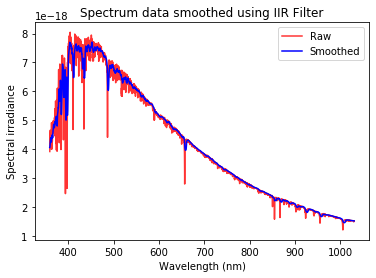

In [7]:
spectrum['Denoised'] = pd.Series(spectrum['Flux']).rolling(25).mean()
spectrum.dropna(subset=['Denoised'],inplace=True)
#cutoff = spectrum.query('λ > 500 and λ < 1000')
#spectrum = cutoff

plt.plot(spectrum['λ'], spectrum['Flux'],"-r",alpha=0.8,label='Raw')
plt.plot(spectrum['λ'], spectrum['Denoised'], "-b",label='Smoothed')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral irradiance')
plt.title('Spectrum data smoothed using IIR Filter')
plt.show()

In [8]:
fit_params, cov_mat = curve_fit(planck, spectrum['λ'], spectrum['Denoised'], p0=[7000,1e-31]) # (function,x,data,init_vals)
uncertainties = np.sqrt(np.diag(cov_mat))
T = fit_params[0]
λ_max = wien(T) # in nm, from temperature in K

spectrum['Scaled BB'] = planck(spectrum['λ'], *fit_params)
spectrum['Blackbody'] = planck(spectrum['λ'],T,1) # calculate absolute spectral luminosity

fit_residual = spectrum['Flux'] - spectrum['Scaled BB']
fit_Rsquared = 1 - np.var(fit_residual)/np.var(spectrum['Flux'])

print('R-squared:',fit_Rsquared,'\n')
print('Obj temperature:',fit_params[0],'\u00b1',uncertainties[0],'K')
print('Scaling factor: ',fit_params[1],'\u00b1',uncertainties[1])
print('Spectrum peak λ:',λ_max,'\u00b1',wien(T)-wien(T+uncertainties[0]),'nm')

R-squared: 0.9023359204987349 

Obj temperature: 6807.78581387979 ± 12.97737811257366 K
Scaling factor:  1.1214150600268557e-31 ± 9.460203661026293e-34
Spectrum peak λ: 425.6555705809648 ± 0.8098643992856296 nm


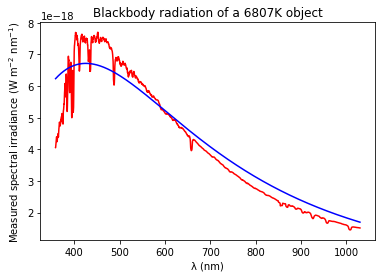

,λ,Flux,Denoised,Scaled BB,Blackbody
24,359.0046,3.915400e-18,4.055128e-18,6.234032e-18,5.559076e+13
25,359.0873,4.070500e-18,4.056420e-18,6.235328e-18,5.560232e+13
26,359.1700,4.261200e-18,4.068564e-18,6.236622e-18,5.561386e+13
27,359.2526,4.413100e-18,4.085688e-18,6.237913e-18,5.562537e+13
28,359.3354,4.466500e-18,4.102180e-18,6.239205e-18,5.563689e+13
...,...,...,...,...,...
4598,1029.2001,1.480700e-18,1.517800e-18,1.702232e-18,1.517932e+13
4599,1029.4374,1.493100e-18,1.516360e-18,1.701195e-18,1.517007e+13
4600,1029.6748,1.516400e-18,1.515916e-18,1.700158e-18,1.516082e+13
4601,1029.9122,1.507700e-18,1.515364e-18,1.699121e-18,1.515158e+13


In [10]:
plt.plot(spectrum['λ'],spectrum['Denoised'],color='red')
plt.ylabel("Measured spectral irradiance (W m$^{-2}$ nm$^{-1}$)")
plt.xlabel("λ (nm)")
plt.plot(spectrum['λ'], spectrum['Scaled BB'], color='blue')
#plt.twinx()
#plt.plot(spectrum['λ'],spectrum['Blackbody'],color='black')
#plt.ylabel("Inferred spectral exitance (W m$^{-2}$ nm$^{-1}$)")
plt.title("Blackbody radiation of a %dK object" %T)
plt.show()
spectrum